<a href="https://colab.research.google.com/github/andygoosh/OneTwoTrip-Contest/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

import random as rn
import pandas as pd
import xarray
import requests
import datetime
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

from keras import layers
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import sklearn.ensemble
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score

import warnings
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

TensorFlow 2.x selected.
Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


2.0.0
2.2.5


RandomState(MT19937) at 0x7F751D326360

In [2]:
df_train = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_train.csv', index_col='orderid')
df_test = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_test.csv', index_col='orderid')

df_train

,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
orderid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10d654494cbe97bbb25d51ead2600679aff9e097924add...,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0
1,4aafc0391f72bbcf60537aece62923baf9ce644b64ac36...,144,-0.393794,5,7,2,0,0,2,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,2,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0
2,bac8ffef46348f587c8d17137ab01fb24aef21547c647d...,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,2,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0
3,0392247b4b87674aba2c32bf2292b105771a6a376871be...,0,-0.238651,10,11,1,1,3,2,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0
4,d1aeefef311bbeb4bd84876c8d49421f276674527d5578...,0,-0.704079,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196051,e33b0b1abb0038261ea9fb5213b9aad000a7686edab9e4...,30,-0.083509,7,7,2,0,0,2,1,0,1,0,91,511,0.459223,1,4,33,7,2,3,1,1,17,1,1,3,1,0,3,1,1,0,1,0,0,0,0,0,0,0
196052,ed64c2d35a57e9e8e8e5bc84f3addf5552e1691a52a75d...,104,-0.548937,11,11,2,0,0,1,1,0,0,8,5,16,-0.521242,1,0,1,5,2,5,1,1,23,1,1,12,3,0,4,1,1,0,0,0,0,0,0,0,0,0
196053,b74f63aae0b4a21b972a8a322f36e7935dbd44fe47762e...,12,0.692205,9,9,3,0,0,2,1,0,1,12,2,12,-0.101043,3,7,3,5,2,5,1,1,2,3,1,12,3,0,3,1,1,1,1,1,0,0,0,0,0,0


In [0]:
def add_polynomial_inner( X, poly ):
  X = X.copy()
  X = pd.DataFrame(poly.transform(X), index=X.index, columns = poly.get_feature_names(X.columns))
  return X
    
def add_polynomial(X_train, X_cv=None, degree=2):
  poly = sklearn.preprocessing.PolynomialFeatures(degree)
  poly.fit(X)
  
  X_train = add_polynomial_inner(X_train, poly)
  if X_cv is not None:
      X_cv = add_polynomial_inner(X_cv, poly)

  #poly_corrs = poly_features.corrwith(y).sort_values(ascending=False)
  #poly_corrs = poly_features.corrwith(y).nlargest(20)

  return X_train, X_cv, poly

In [0]:
def add_neughbors_inner( X, neigh ):
    X = X.copy()
    dists, _ = neigh.kneighbors(X, return_distance=True)
    X['K-mean'] = dists.mean(axis=1).reshape(-1, 1)
    X['K-max'] = dists.max(axis=1).reshape(-1, 1)
    return X

def add_neighbors(X_train, X_cv=None, n_neighbors=5):
  neigh = skl.neighbors.NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
  neigh.fit(X_train)

  X_train = add_neughbors_inner(X_train, neigh)
  if X_cv is not None:
      X_cv = add_neughbors_inner(X_cv, neigh)

  return X_train, X_cv, neigh

In [0]:
def prepare_data( data ):

  X = data.copy()
  y = []

  FTS = list(filter(lambda x: 'field' in x, data.columns))
  X = X[FTS]

  #f7 = pd.DataFrame(keras.utils.to_categorical(X['field7'] - 1).astype(int), index=X.index, columns=['field7_0', 'field7_1'])
  #X.drop(['field7'], axis=1, inplace=True)
  #X = X.join(f7)



  # drop overfitting fts
  #X.drop(['field16'], axis=1, inplace=True)

  # add polimonial
  X['field7_field16'] = X['field7'] * X['field16']
  X['field16_field17'] = X['field16'] * X['field17']
  #X['field16_field25'] = X['field16'] * X['field25']
  X['field12_field16'] = X['field12'] * X['field16']
  X['field7_field12'] = X['field7'] * X['field12']
  X['field12_field25'] = X['field12'] * X['field25']

  # drop unimportant or negatively impacting
  X.drop(['field0', 'field29', 'field28'], axis=1, inplace=True)

  if  'goal1' in data.columns:
      y = data[['goal1']]

  return X, y

In [0]:
X.describe()

In [0]:
#corrs = X.corrwith(y).sort_values(ascending=False)
corrs = X.corrwith(y).nlargest(20)
corrs

Series([], dtype: float64)

In [0]:
def fit_estimate( X, y, model_generator, n_folds = 5, n_neighbors=0, degree=0):

  scores = []
  models = []
  neighbs = []
  polies = []

  folds = list(skl.model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=RS).split(X, y))
  for j, (train_idx, val_idx) in enumerate(folds):
    print('[{:}/{:}]'.format(j+1,n_folds) , end='')

    X_train, X_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_cv = y.iloc[train_idx], y.iloc[val_idx]

    if degree > 1:
      X_train, X_cv, poly = add_polynomial(X_train, X_cv, degree)
      polies.append(poly)
    
    if n_neighbors > 0:
      X_train, X_cv, neigh = add_neighbors(X_train, X_cv, n_neighbors)
      neighbs.append(neigh)

    model = model_generator()
    model.fit(X_train, y_train.values.ravel())

    y_pred_cv = model.predict_proba(X_cv)
    y_hotted = pd.DataFrame(keras.utils.to_categorical(y_cv), index=y_cv.index)
    #y_hotted.drop([0, 7], axis=1, inplace=True)

    scores.append(skl.metrics.roc_auc_score(y_hotted, y_pred_cv))
    models.append(model)

  print('{:} cv: {:.4f} ± {:.4f}.'.format(type(model).__name__, np.mean(scores), np.std(scores)))
  return scores, models, neighbs, polies

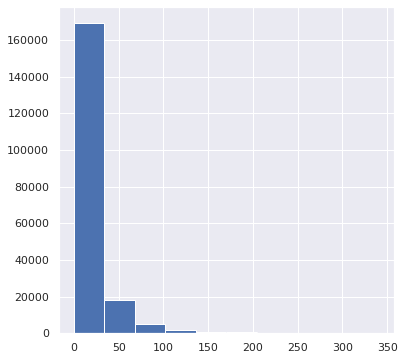

In [48]:
X['field16'].hist()

In [0]:
model.get_params()

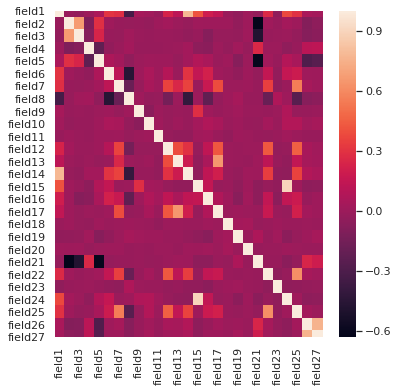

In [43]:
import seaborn as sns; sns.set()
ax = sns.heatmap(X.corr())

In [44]:
X['field15'].corr(X['field24'])

0.8997383624723512

In [108]:
X, y = prepare_data( df_train )

#n_bins = 20
#est = skl.preprocessing.KBinsDiscretizer(n_bins=n_bins, encode='onehot-dense', strategy='uniform')
#m = pd.DataFrame(est.fit_transform(X[['field16']]).astype(int), index=X.index, columns=['field16_bin%d' % i for i in range(n_bins)])

#est = skl.preprocessing.KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
#X['field16'] = est.fit_transform(X[['field16']]).astype(int)

estimators = 157

params = {'base_score': 0.5,
 'booster': 'gbtree',
 'class_weight': 'balanced',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 0.6,
 'missing': None,
 'n_estimators': estimators,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': RS,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.9,
 'verbosity': 1}

def_params = {
    'random_state': RS,
    'n_estimators': estimators,
    'n_jobs': -1
}

scores, models, neighbs, polies = fit_estimate(X, y, lambda: XGBClassifier(**params), n_folds=5, n_neighbors=5)
model = models[np.argmax(scores)]

neigh = neighbs[np.argmax(scores)]
X = add_neughbors_inner(X, neigh)
'''
poly = polies[np.argmax(scores)]
X = add_polynomial_inner(X, poly)
'''
print(model.score(X, y))

#[1/5][2/5][3/5][4/5][5/5]XGBClassifier CV: 0.6876 ± 0.0086. params fine tuning, -f0
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier CV: 0.6881 ± 0.0090. params fine tuning, -f0, f28 +5 neigh
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier cv: 0.6885 ± 0.0078. polinomial, 0 neigh
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier cv: 0.6895 ± 0.0111. polimonial, 5 neigh

[1/5][2/5][3/5][4/5][5/5]XGBClassifier cv: 0.6895 ± 0.0111.
0.9779603786673196


In [36]:
X['field6'].value_counts()

0      152779
1        6618
3        5623
2        5579
4        4103
        ...  
323         1
150         1
101         1
102         1
126         1
Name: field6, Length: 147, dtype: int64

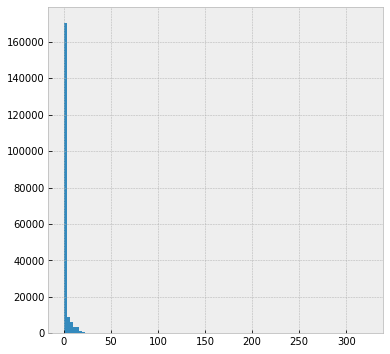

In [35]:
plt.hist(X['field6'], bins=100);


In [109]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
15,field16,0.359550
11,field12,0.182122
20,field21,0.117335
9,field10,0.112454
1,field2,0.068475
...,...,...
4,field5,0.009028
23,field24,0.005888
8,field9,0.004926
7,field8,0.004247


Index(['field7_field16', 'field16_field25', 'K-max', 'field21', 'field12',
       'field12_field16', 'field7_field12', 'K-mean', 'field16_field17',
       'field10', 'field1', 'field27', 'field12_field25', 'field9', 'field18',
       'field11', 'field6', 'field19', 'field5', 'field2'],
      dtype='object')


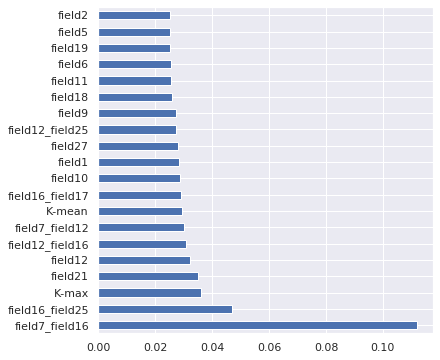

In [104]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
print(feat_importances.nlargest(20).index)

CPU times: user 2min 5s, sys: 55.8 ms, total: 2min 6s
Wall time: 1min 4s


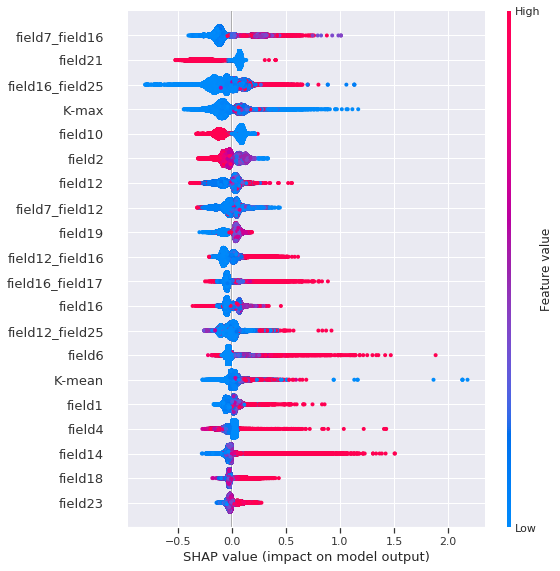

In [105]:
import shap
%time shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X)

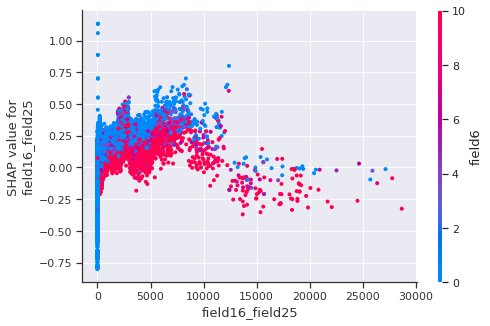

In [106]:
shap.dependence_plot("field16_field25", shap_values, X)

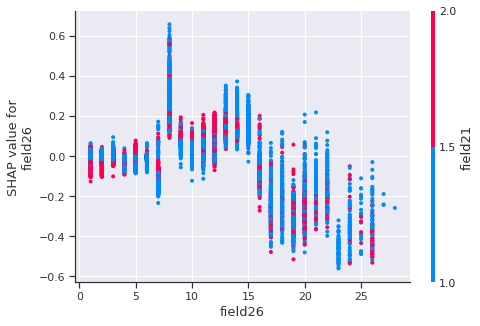

In [94]:
shap.dependence_plot("field26", shap_values, X)

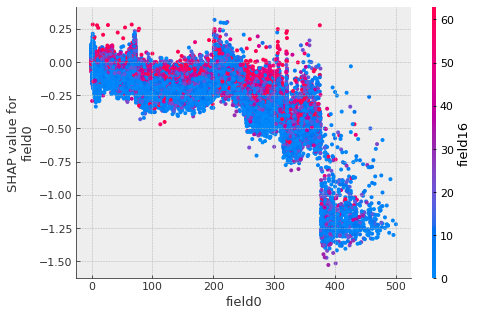

In [86]:
shap.dependence_plot("field0", shap_values, X)

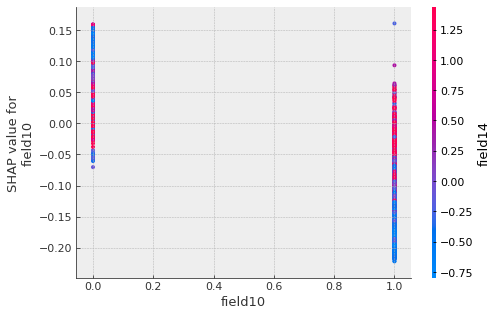

In [94]:
shap.dependence_plot("field10", shap_values, X)

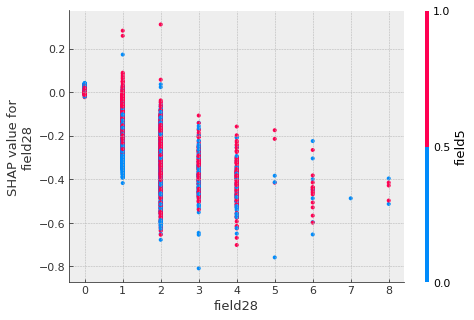

In [97]:
shap.dependence_plot("field28", shap_values, X)

In [58]:
cols_ = feat_importances.sort_values(ascending=False)
X[cols_.index].describe()

,field16,field7,field12,field10,field21,field8,field6,dow1,month1,field9,field22,field14,field27,field0,field1,hour2,field13,field5,hour1,dow2,field19,field26,month2,field25,field24,field17,field15,field28,field4,field29
count,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000
mean,15.723854,1.265292,12.010492,0.448117,1.226471,0.879366,1.577911,3.811941,7.980363,0.023937,38.751938,0.001822,1.746557,28.413163,0.000912,13.028186,27.046028,0.556214,14.633431,3.993762,2.076172,3.875780,7.867864,4.923456,1.404645,3.001301,1.517153,0.088572,3.528966,2.980837
std,25.689926,0.441489,19.579464,0.497302,0.418548,0.325702,5.614900,1.931365,2.757008,0.164366,71.517212,1.007327,1.376456,69.603944,1.009651,6.132370,55.490962,0.496831,5.519693,1.975246,0.980940,4.230396,3.013659,11.652149,0.784647,8.510708,0.952774,0.369773,12.692057,0.919229
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-0.941441,1.000000,0.000000,-0.859222,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,4.000000,0.000000,1.000000,1.000000,0.000000,2.000000,6.000000,0.000000,1.000000,-0.521242,1.000000,0.000000,-0.471365,8.000000,3.000000,0.000000,11.000000,2.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000
50%,6.000000,1.000000,5.000000,0.000000,1.000000,1.000000,0.000000,4.000000,8.000000,0.000000,17.000000,-0.241109,1.000000,0.000000,-0.238651,13.000000,4.000000,1.000000,15.000000,4.000000,2.000000,2.000000,8.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000
75%,18.000000,2.000000,11.000000,1.000000,1.000000,1.000000,0.000000,5.000000,10.000000,0.000000,42.000000,0.179090,3.000000,13.000000,0.149205,18.000000,26.000000,1.000000,19.000000,6.000000,3.000000,5.000000,10.000000,1.000000,2.000000,1.000000,2.000000,0.000000,2.000000,4.000000
max,340.000000,2.000000,273.000000,1.000000,2.000000,1.000000,323.000000,7.000000,12.000000,4.000000,867.000000,55.225183,7.000000,500.000000,82.142134,23.000000,746.000000,1.000000,23.000000,7.000000,8.000000,28.000000,12.000000,170.000000,18.000000,156.000000,18.000000,8.000000,363.000000,4.000000


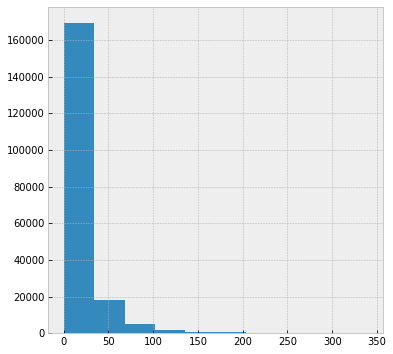

In [80]:
X['field16'].hist()

In [27]:
X, y = prepare_data( df_train )

params = {'base_score': 0.5,
 'booster': 'gbtree',
 'class_weight': 'balanced',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 0.5,
 'missing': None,
 'n_estimators': 340,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 77,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

parameters_xgb = { 
    'n_estimators': [158, 159], #_100
    }

clf = XGBClassifier(random_state=RS)

GS = GridSearchCV(clf, 
                  parameters_xgb, 
                  cv=KFold( n_splits = 5, shuffle=True, random_state=RS),
                  verbose=10, 
                  n_jobs=-1,
                  scoring='roc_auc')
GS.fit(X, y)
print( GS.best_params_ )
print( GS.best_score_ )

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.0s


KeyboardInterrupt: ignored

## Submit the result

In [0]:
X_test, _ = prepare_data( df_test )

X_test = add_neughbors_inner(X_test, neigh)

proba = model.predict_proba(X_test)
pd.DataFrame(proba[:, 1], columns=['proba'], index=X_test.index).to_csv('sub1.csv')

In [0]:
!zip sub1.csv.zip sub1.csv

updating: sub1.csv (deflated 63%)


In [0]:
!pip3 install eli5
import eli5
from eli5.sklearn import PermutationImportance

In [0]:
!pip3 install catboost
from catboost import CatBoostClassifier

In [0]:
!pip install shap